## 매 시도마다 돌릴 것들

In [98]:
from google.colab import drive
drive.mount('/content/drive')
!pip install datasets --quiet

import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

data_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data/'  # 이미지 및 텍스트 파일 폴더

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from collections import Counter
from tqdm import tqdm
from collections import Counter
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoConfig
from scipy.special import softmax
import shutil
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 전처리

In [31]:
# 텍스트 데이터 로드
texts_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/texts.csv')
label_txt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/label.txt', sep='\t', header=0)
label_txt.columns = ['ID', 'Annotator1', 'Annotator2', 'Annotator3']
label_jpg = label_txt.copy()

def pre_text(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

texts_df['Text'] = texts_df['Text'].apply(pre_text)

In [32]:
dic = {'positive': 1, 'neutral':0, 'negative': -1}
def pre_labeltext(text):
    new_text = text.split(",")[0]
    return dic[new_text]
label_txt['Annotator1'] = label_txt['Annotator1'].apply(pre_labeltext)
label_txt['Annotator2'] = label_txt['Annotator2'].apply(pre_labeltext)
label_txt['Annotator3'] = label_txt['Annotator3'].apply(pre_labeltext)
label_txt['label'] = label_txt['Annotator1'] + label_txt['Annotator2'] + label_txt['Annotator3']
label_txt['label'] = label_txt['label']/3
label_txt = label_txt.drop(['Annotator1', 'Annotator2', 'Annotator3'], axis=1)

In [33]:
def pre_labeltext(text):
    new_text = text.split(",")[1]
    return dic[new_text]
label_jpg['Annotator1'] = label_jpg['Annotator1'].apply(pre_labeltext)
label_jpg['Annotator2'] = label_jpg['Annotator2'].apply(pre_labeltext)
label_jpg['Annotator3'] = label_jpg['Annotator3'].apply(pre_labeltext)
label_jpg['label'] = label_jpg['Annotator1'] + label_jpg['Annotator2'] + label_jpg['Annotator3']
label_jpg['label'] = label_jpg['label']/3
label_jpg = label_jpg.drop(['Annotator1', 'Annotator2', 'Annotator3'], axis=1)

In [35]:
# 라벨 데이터와 텍스트 데이터 병합
merged_text = pd.merge(label_txt, texts_df, on='ID')

## 데이터 라벨링-모델 일치율 확인(만족스럽다)

In [90]:
def checksentiment(listtexts, listlabels):
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    batch_size = 16
    sentiment_scores = []

    for i in tqdm(range(0, len(listtexts), batch_size)):
        batch_texts = listtexts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        encoded_input.to(device)

        with torch.no_grad():
            outputs = model(**encoded_input)

        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        scores = probabilities.cpu().numpy()

        pos_probs = scores[:, 2]  # 긍정 확률
        neg_probs = scores[:, 0]  # 부정 확률
        sentiments = pos_probs - neg_probs  # 감성 점수
        sentiment_scores.extend(sentiments)

    listlabels = np.array(listlabels)
    sentiment_scores = np.array(sentiment_scores)

    # L2 Loss
    l2_loss = np.mean((sentiment_scores - listlabels) ** 2)
    print(f"L2 Loss: {l2_loss}")

    return sentiment_scores

In [160]:
lab = merged_text['label'].tolist()
sentiment_scores = checksentiment(merged_text['Text'].tolist(), lab)
check = 0
for i in range(len(actual_labels)):
    if (abs(sentiment_scores[i] - lab[i]) > 0.4) or (sentiment_scores[i] * lab[i] < 0):
        check+=1
check

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1225/1225 [00:19<00:00, 61.31it/s]

L2 Loss: 0.22832325209626356


4706

## 이미지 설명-감성 분석 점수 확인(학습 전 저성능 확인)

In [89]:
#자기 전에 켜 둘 것
source_dir = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data'

target_dir = '/content/data'

# 대상 폴더가 없으면 생성
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

loader = label_txt['ID'].tolist()

for filename in tqdm(loader):
    filename_with_ext = f"{filename}.jpg"
    src_file = os.path.join(source_dir, filename_with_ext)
    dst_file = os.path.join(target_dir, filename_with_ext)

    try:
        shutil.copy2(src_file, dst_file)
    except Exception as e:
        print(f"파일 복사 중 오류 발생: {filename_with_ext}, 오류: {e}")

100%|██████████| 19600/19600 [1:57:19<00:00,  2.78it/s]


In [76]:
scores = np.array(sentiment_scores)
sim = label_jpg['label'] * label_txt['label'] > 0
label_jpg['pred'] = scores
input_df = label_jpg[sim]

In [ ]:
image_dir = '/content/data'
def jpg(num):
    return f"{num}.jpg"
image_ids = input_df['ID'].apply(jpg).tolist()
actual_labels = input_df['pred'].tolist()
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
model_blip.to(device)

In [100]:
captions = []

for image_id in tqdm(image_ids):

    image_path = os.path.join(image_dir, image_id)

    # 이미지 로드 및 전처리
    try:
        raw_image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"이미지 로드 실패: {image_id}, 오류: {e}")
        captions.append("")  # 빈 문자열 추가하여 인덱스 맞추기
        continue

    # 입력 데이터 생성
    inputs = processor(images=raw_image, return_tensors="pt").to(device)

    # 캡션 생성
    with torch.no_grad():
        out = model_blip.generate(**inputs)

    # 캡션 디코딩
    caption = processor.decode(out[0], skip_special_tokens=True)
    captions.append(caption)

  0%|          | 0/12850 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  6%|▌         | 707/12850 [03:47<50:37,  4.00it/s]  

이미지 로드 실패: 3910.jpg, 오류: cannot identify image file '/content/data/3910.jpg'


 16%|█▌        | 2001/12850 [10:32<59:20,  3.05it/s]

이미지 로드 실패: 5995.jpg, 오류: cannot identify image file '/content/data/5995.jpg'


100%|██████████| 12850/12850 [1:09:18<00:00,  3.09it/s]


In [163]:
sentiment_scores = checksentiment(captions, actual_labels)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 804/804 [00:08<00:00, 90.41it/s]

L2 Loss: 0.5017479144824811


In [164]:
check = 0
for i in range(len(actual_labels)):
    if (abs(sentiment_scores[i] - actual_labels[i]) > 0.4) or (sentiment_scores[i] * actual_labels[i] < 0):
        check+=1
check

9873

<Axes: ylabel='Count'>

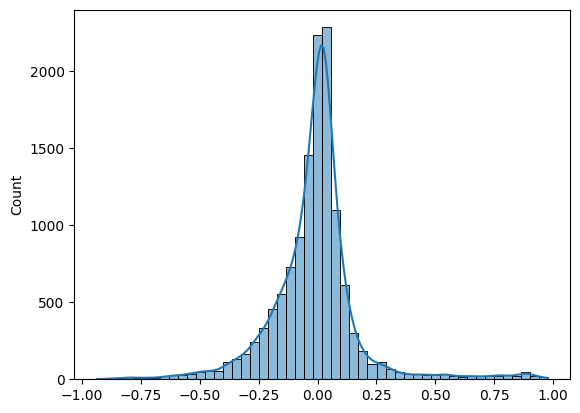

In [168]:
sns.histplot(sentiment_scores, bins=50, kde=True)

## 멀티모달 이미지 감성-설명 학습

blip의 max_new_tokens값 실제 텍스트들 보고 길이 조정할것

그냥 모델이 긍정적인 애가 될 가능성 조심할것(밀도비례로 넣어서 재확인할 필요 있음)

(내일 수업 가기 전 학습 돌려놓고 나갈 것)